# Air Quality

Дорогой проверяющий. 

К сожалению я сильно заболел, и работу делал с большим трудом. У меня сильная температура и кашель, но врачи говорят, что это не корона вирус. Прошу сделать небольшую скидку, так как печатать тяжело. 

# Imports

In [464]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from IPython.display import Image
import random
from sklearn import linear_model
import statsmodels.api as sm
import statsmodels.stats.api as sms
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Options

In [2]:
pd.set_option('display.max_columns', None)

# Commonly used constants and paths

In [149]:
SEED = 43
DATA_PATH = 'data'
DF_PATH = f'{DATA_PATH}/raw/AirQualityUCI.csv'
TARGET = 'C6H6(GT)'
NAN_CATEGORY = '<NAN>'
SEP = ';'

# Random Seed 

In [150]:
random.seed(SEED)

# Functions

In [454]:
def add_na(series, count):
    for n in range(random.randint(5,count)):
        i = random.randint(1, len(series))
        for x in range(10, random.randint(20, 40)):
            series[i+x] = np.nan
            
        
def test(models, data, X, Y, iterations = 100):
    results = {}
    for i in models:
        r2_train = []
        r2_test = []
        for j in range(iterations):
            X_train, X_test, y_train, y_test = train_test_split(data[X], 
                                                                data[Y], 
                                                                test_size= 0.2)
            r2_test.append(r2_score(y_test,
                                            models[i].fit(X_train, 
                                                         y_train).predict(X_test)))
            r2_train.append(r2_score(y_train, 
                                             models[i].fit(X_train, 
                                                          y_train).predict(X_train)))
        results[i] = [np.mean(r2_train), np.mean(r2_test)]
    return pd.DataFrame(results)


def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def split_data( data, split_date ):
    return data.loc[data.index <= split_date].copy(), \
           data.loc[data.index >  split_date].copy()


class Model():
    
    def __init__(self, df , h = 3 , p = 14, k = 6, percentile = 10, g_max_depth = 5, g_n_estimators = 100):
        self.df = df 
        self.h = h
        self.p = p
        self.k = k
        self.y, self.scl_target = self.scale_scl_y()
        self.X, self.scl_x = self.scale_scl_x()
        self.f = self.f_test()
        self.sfk, self.X_new = self.select_k_best()
        self.percentile = percentile
        self.sfp, self.X_new2 = self.select_p()
        self.g_max_depth = g_max_depth
        self.g_n_estimators = g_n_estimators
        self.sfm, self.X_new3 = self.gr_model_estimator()
        self.X_n = self.print_params()
    
    def scale_scl_y(self):
        scl_target = StandardScaler()
        target_1 = self.df[TARGET].values[self.h+self.p:].reshape((self.df.shape[0]-self.h-self.p,1))
        y = scl_target.fit_transform(target_1)
        print(f'y shape after noramalize - {y.shape}')
        return y, scl_target
    
    def scale_scl_x(self):
        scl_x=StandardScaler() 
        X = self.df.iloc[self.p:-self.h,:].values
        X = scl_x.fit_transform(X.astype('float64'))
        print(f'X shape after normalize - {X.shape}')
        return X, scl_x
    
    def f_test(self):
        f_test, _ = f_regression(self.X, self.y.ravel())
        f_test /= np.nanmax(f_test)
        print(f'Значения F-test')
        for i in range(self.X.shape[1]):
            print("F-test={:.2f},  I={}".format(f_test[i],i))
    
    
    def select_k_best(self):
        sfk =SelectKBest(f_regression, k = self.k)
        X_new =sfk.fit_transform(self.X, self.y.ravel())
        print(f'SelectKBest  shape - {X_new.shape}')
        return sfk, X_new
    
    def select_p(self):
        sfp=SelectPercentile(f_regression, percentile=self.percentile)
        X_new2 = sfp.fit_transform(self.X, self.y.ravel())
        print(f'SelectKBest  shape - {X_new2.shape}')
        return sfp, X_new2
        
    def gr_model_estimator(self):
        gr_model = GradientBoostingRegressor(max_depth=self.g_max_depth, random_state=40, n_estimators = self.g_n_estimators).fit(self.X, self.y.ravel())
        sfm = SelectFromModel(gr_model,  max_features = self.k)
        sfm.fit(self.X, self.y.ravel())
        X_new3 = sfm.transform(self.X)
        print(f'GradientBoostingRegressor - {X_new3.shape}')
        return sfm, X_new3
        
    def print_params(self):
        list_param_k =np.where(self.sfk.get_support())[0]
        list_param_p =np.where(self.sfp.get_support())[0]
        list_param_m =np.where(self.sfm.get_support())[0]

        print('Номера признаков k лучших признаков : ',list_param_k)
        print('Номера признаков лучших признаков по процентной форме: ',list_param_p)
        print('Номера признаков для выбора по модели : ',list_param_m)
        columns = np.intersect1d(list_param_k , list_param_p)
        columns = np.unique(np.concatenate((columns, list_param_m[1:]), 0))
        #print(f'Фичи - {columns} \n Хотите дополнить список?')
        #c = int(input())
        print(f'Самые важные фичи - {columns}')
        X_n = self.X[:,columns]
        return X_n

    
class Error_count():

    def __init__(self, y_true, y_test_pred_g, scl_target):
        self.y_true = y_true
        self.scl_target = scl_target
        self.y_test_pred_g = y_test_pred_g
        self.er_s, self.er_a, self.er_r2 = self.error_c()
        self.er_g = self.mean_absolute_percentage_error()
        
        
    def error_c(self):
        er_s = mean_squared_error(y_true=self.y_true, y_pred=self.y_test_pred_g) 
        er_a = mean_absolute_error(y_true=self.y_true, y_pred=self.y_test_pred_g) 
        er_r2 = r2_score(y_true=self.y_true, y_pred=self.y_test_pred_g)

        print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)
           
        return er_s, er_a, er_r2
    
    def mean_absolute_percentage_error(self): 
        y_true, y_pred = np.array(self.scl_target.inverse_transform(self.y_true)), np.array(self.y_test_pred_g)
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        print('#TODO тут явно ошибка вычисления')
        print(f'ошибка градиентного бустинга MAPE : {mape} %')
        return mape
    
    
class Split_data():
    
    def __init__(self, df, X, y, split_date  = '06-2018'):
        self.X = X 
        self.df = df
        self.y = y
        self.split_date = split_date
        self.train_index, self.test_index = self.split_data()
        self.X_train, self.y_train, self.X_test, self.y_test = self.X_y_train_test()
        
    def split_data(self):
        return self.df.loc[self.df.index <= self.split_date].copy(), \
               self.df.loc[self.df.index >  self.split_date].copy()
    
    def X_y_train_test(self):
        return  self.X[:self.train_index.shape[0],:], \
                self.y[:self.train_index.shape[0],0], \
                self.X[self.train_index.shape[0]:,:], \
                self.y[self.train_index.shape[0]:,0]

# Data preporation

In [13]:
df = pd.read_csv(DF_PATH, sep=SEP)

In [15]:
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",NaN,NaN
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",NaN,NaN


In [16]:
df.drop(['Unnamed: 15', 'Unnamed: 16'], axis=1, inplace=True)

In [17]:
df[df.isnull().any(axis=1)]

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
9357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df.dropna(how='all', inplace=True)

In [19]:
df['datetime'] = df['Date'] + ':' + df['Time']
df['datetime'] = pd.to_datetime(df['datetime'], format="%d/%m/%Y:%H.%M.%S")
df.set_index('datetime', inplace=True)

In [22]:
pd.date_range(start = df.index.min(), end = df.index.max() , freq='H').difference(df.index)

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [23]:
df.drop(['Date', 'Time'], axis=1, inplace=True)

In [25]:
df.dtypes

CO(GT)           float64
PT08.S1(CO)      float64
NMHC(GT)         float64
C6H6(GT)         float64
PT08.S2(NMHC)    float64
NOx(GT)          float64
PT08.S3(NOx)     float64
NO2(GT)          float64
PT08.S4(NO2)     float64
PT08.S5(O3)      float64
T                float64
RH               float64
AH               float64
dtype: object

In [24]:
df['C6H6(GT)'] = df['C6H6(GT)'].str.replace(',','.').astype('float')
df['T'] = df['T'].str.replace(',','.').astype('float')
df['RH'] = df['RH'].str.replace(',','.').astype('float')
df['AH'] = df['AH'].str.replace(',','.').astype('float')
df['CO(GT)'] = df['CO(GT)'].str.replace(',','.').astype('float')

In [26]:
df.replace([-200, -200.0], np.nan, inplace=True)

In [27]:
df.isna().sum()

CO(GT)           1683
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
dtype: int64

In [28]:
c_366 = ['PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)',  'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']
c_1700 = ['CO(GT)', 'NOx(GT)', 'NO2(GT)']
c_9000 = ['NMHC(GT)']

# Resume 

1. I deleted to empty columns with no values. I think it`s a error of reading dataframe.

2. I checked for na values and come to conclusion that all values of the tail of dataframe is empty in echa column. Defently they have to be removed.

3. This data set for sure is the time series. So I split columns Date and Time to make a time index. 

4. Some of features was wrong type, and I covert them to appropriate one.

5. As had been told in DF desription null values was writen as -200 so I converted them to numpy na

6. I selected 3 types of na values, The first where na count is 366, and this series is na in evety column. The Second - where na values ~ 1670, and The third - one column where na values close to 90% of DF is NMHC(GT) 

# EDA

Data Set Information:

The dataset contains 9358 instances of hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. The device was located on the field in a significantly polluted area, at road level,within an Italian city. Data were recorded from March 2004 to February 2005 (one year)representing the longest freely available recordings of on field deployed air quality chemical sensor devices responses. Ground Truth hourly averaged concentrations for CO, Non Metanic Hydrocarbons, Benzene, Total Nitrogen Oxides (NOx) and Nitrogen Dioxide (NO2) and were provided by a co-located reference certified analyzer. Evidences of cross-sensitivities as well as both concept and sensor drifts are present as described in De Vito et al., Sens. And Act. B, Vol. 129,2,2008 (citation required) eventually affecting sensors concentration estimation capabilities. Missing values are tagged with -200 value. This dataset can be used exclusively for research purposes. Commercial purposes are fully excluded.


Few words about the research

Low cost gas multisensor devices can represent an efficient solution for densifying the 
sparse  urban  air  pollution  monitoring  mesh.Conventional air pollution monitoring station is used to provide reference data. 


A multisensor device, developed by Pirelli Labs (see ref. [12]), has been co-located with 
a conventional air pollution analyzer, operated by the regional environmental protection 
agency (ARPA). The conventional analyzer response has been used to provide the true 
concentration values of the target pollutants at the measurement site. These values have 
been  hence  used  as  a  reference  for  the  tuning  of  a  multivariate  regression  system 
designed for calibrating the multisensor device response. This multisensor device was 
designed to host five custom metal oxide chemoresistive sensors plus two commercial 
Relative Humidity and Temperature solid state  sensors. It is built on a very compact 
design (volume=9.7*10-3 m3) and was easily deployed in the operative scenario due to 
its  limited  weight  (less  than  2.5  Kg).  An  on  board  microcontroller  provided  the 
computing  platform,  controlling  analog  to  digital  conversion,  while  an  on  board 
secondary  memory device  provided  local storing  capacity for  up  to 72  hrs of  data 
measurement, with a 8 s sampling period. Hourly average of measurements was being 
transmitted  via  a  GPRS  modem  toward  PC  class  data  sinks. 

# Conclusion

From the papers added to dataset we know that all features have a strong correlation with the target. An exhaustive describshion of a target feature is given in papers. So I dont want to copy it. 

Else from papers the explore the PT08.S1(CO) feature as one of the most important feature to make a good predictions to the target. 

All features have the same type - numeric

In [36]:
df.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,7674.000000,8991.000000,914.000000,8991.000000,8991.000000,7718.000000,8991.000000,7715.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000
mean,2.152750,1099.833166,218.811816,10.083105,939.153376,246.896735,835.493605,113.091251,1456.264598,1022.906128,18.317829,49.234201,1.025530
std,1.453252,217.080037,204.459921,7.449820,266.831429,212.979168,256.817320,48.370108,346.206794,398.484288,8.832116,17.316892,0.403813
min,0.100000,647.000000,7.000000,0.100000,383.000000,2.000000,322.000000,2.000000,551.000000,221.000000,-1.900000,9.200000,0.184700
25%,1.100000,937.000000,67.000000,4.400000,734.500000,98.000000,658.000000,78.000000,1227.000000,731.500000,11.800000,35.800000,0.736800
50%,1.800000,1063.000000,150.000000,8.200000,909.000000,180.000000,806.000000,109.000000,1463.000000,963.000000,17.800000,49.600000,0.995400
75%,2.900000,1231.000000,297.000000,14.000000,1116.000000,326.000000,969.500000,142.000000,1674.000000,1273.500000,24.400000,62.500000,1.313700
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


As we can see in a table above, there is stong skewness to the right in all features, becouse the max value much more bigger than 3 quantile. Only 1 feature have a negative value - Temperature.

# Important preparation

Before futher analizes I have to do DF without NA in order to do Pearson Correlation Test.

Column with more than 8000 na values, I can remove now for sure. For this analize I drop columns with 1600 empty values and drop na values in columns with 300 na values. I will be back to this columns after experiment.

In [99]:
dfn = df.drop(c_1700, axis=1)
dfn = dfn.drop(c_9000, axis=1)
dfn = dfn.dropna(subset=c_366, axis=0, how='all')

In [100]:
dfn.isna().sum()

PT08.S1(CO)      0
C6H6(GT)         0
PT08.S2(NMHC)    0
PT08.S3(NOx)     0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64

# PT08.S1(CO)

I will start solve na problem from this featurea which I know from a paper as one of the most important mesuares in the experiment. I will do some analizise before I choose what type of regression or interpolation I should use to get a better score in a filling na quizz.

In [101]:
dfn['PT08.S1(CO)'].describe()

count    8991.000000
mean     1099.833166
std       217.080037
min       647.000000
25%       937.000000
50%      1063.000000
75%      1231.000000
max      2040.000000
Name: PT08.S1(CO), dtype: float64

Mean and median are where close. Std is relativelly small. And max values twice as big as 3 quartile. So distribution of the values is skewed to the right or have some big outliers 

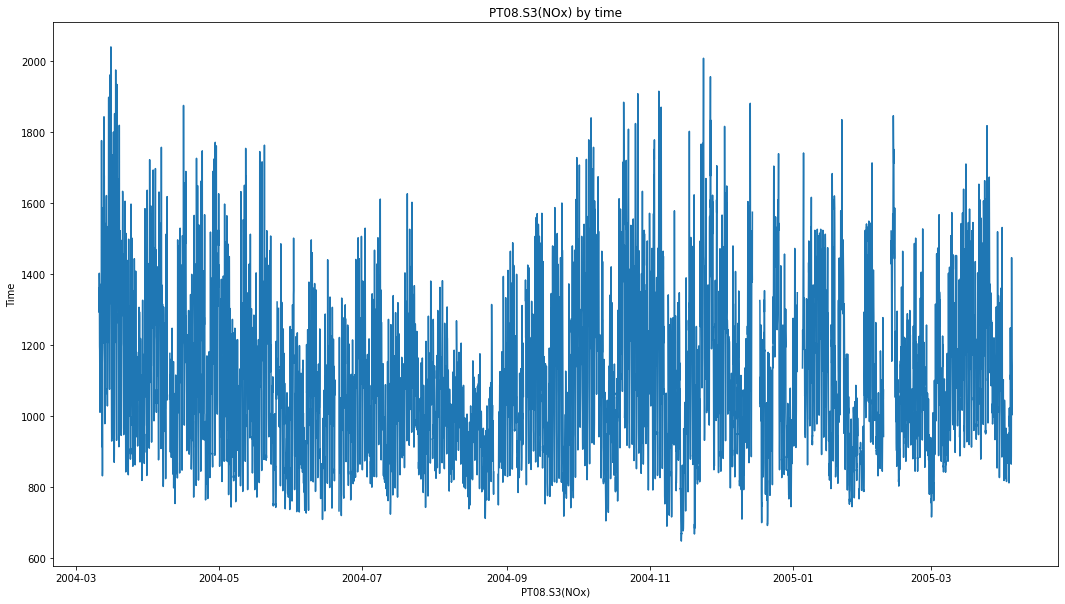

In [102]:
plt.figure(figsize=(18,10))
plt.plot(df.index,df['PT08.S1(CO)'])
plt.title('PT08.S3(NOx) by time')
plt.xlabel('PT08.S3(NOx)')
plt.ylabel('Time')
plt.show()

The strange episode happends in the end of 2004-08. We see that there are no regular splikes and frequensy is pretty low. 

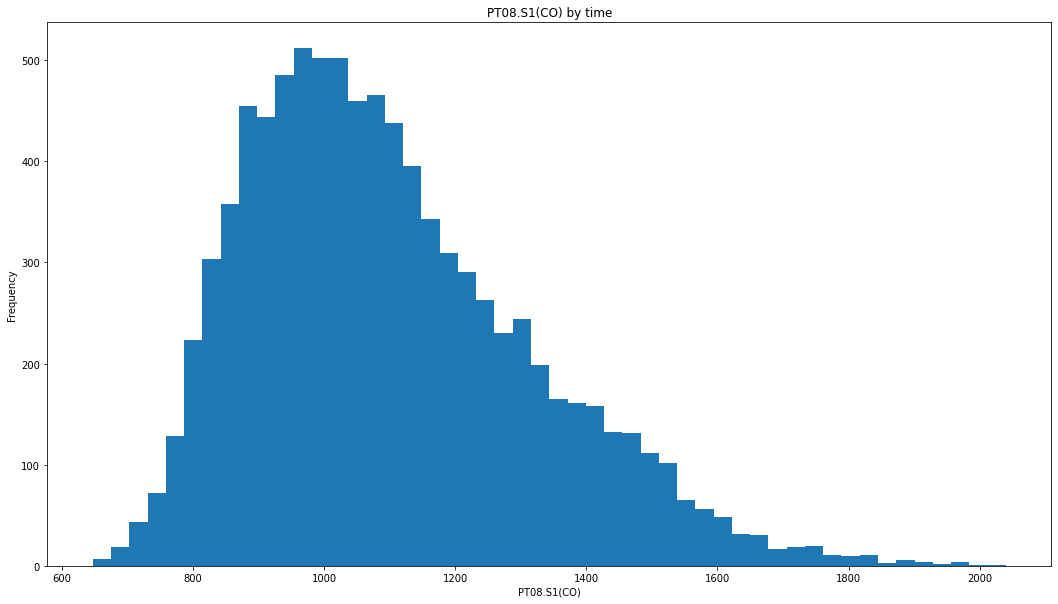

In [103]:
plt.figure(figsize=(18,10))
plt.hist(df['PT08.S1(CO)'], bins = 50)
plt.title('PT08.S1(CO) by time')
plt.xlabel('PT08.S1(CO)')
plt.ylabel('Frequency')
plt.show()

Its like a normal distribution with big skew to the hight values. I want to see on the first diff.

In [104]:
dfn['PT08.S1(CO)_dif1'] = dfn['PT08.S1(CO)'].diff()

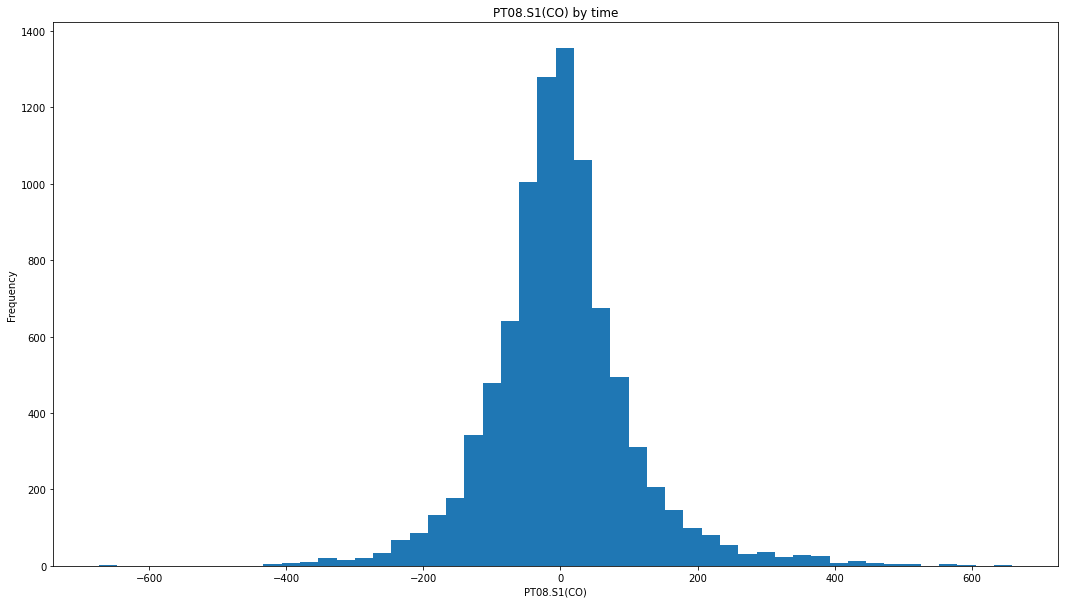

In [105]:
plt.figure(figsize=(18,10))
plt.hist(dfn['PT08.S1(CO)_dif1'], bins = 50)
plt.title('PT08.S1(CO) by time')
plt.xlabel('PT08.S1(CO)')
plt.ylabel('Frequency')
plt.show()

It`s looks exactly as normal distribution. We can assume that there is a trend in origin feature.

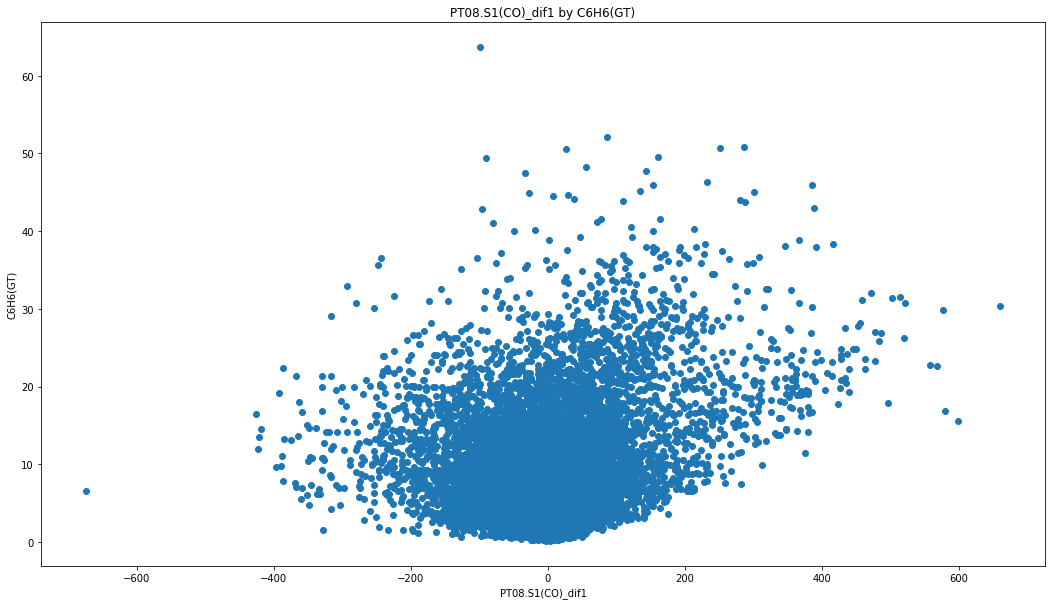

In [108]:
plt.figure(figsize=(18,10))
plt.scatter(dfn['PT08.S1(CO)_dif1'], dfn[TARGET])
plt.title('PT08.S1(CO)_dif1 by C6H6(GT)')
plt.xlabel('PT08.S1(CO)_dif1')
plt.ylabel('C6H6(GT)')
plt.show()


In [109]:
stats.pearsonr(dfn['PT08.S1(CO)_dif1'][1:], dfn[TARGET][1:])

(0.26462762333354206, 6.395791549108485e-144)

With a strong confidence we can say assert that there is a low correlation between the first difference of feature PT08.S1(CO) and the Target 

I want to find out whether the change in PT08.S1(CO) earlier in time can predict the change in C6H6(GT) later in time . 

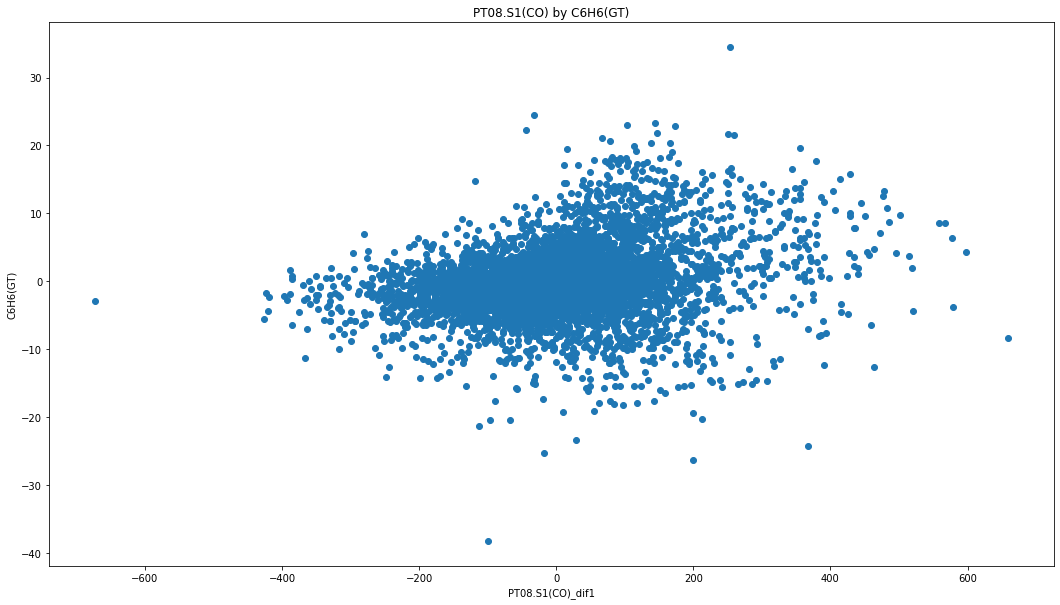

In [110]:
plt.figure(figsize=(18,10))
plt.scatter(dfn['PT08.S1(CO)_dif1'].shift(1), dfn[TARGET].diff())
plt.title('PT08.S1(CO) by C6H6(GT)')
plt.xlabel('PT08.S1(CO)_dif1')
plt.ylabel('C6H6(GT)')
plt.show()

In [111]:
stats.pearsonr(dfn['PT08.S1(CO)_dif1'][1:].shift(1)[2:], dfn[TARGET][1:].diff()[2:])

(0.2632553077356944, 2.2862695057588538e-142)

With a strong confidence we can say assert that there is a low correlation between the first difference and shift hour before of feature PT08.S1(CO) and the Target without trend

So Ill make another feature from PT08.S1(CO)

In [112]:
dfn['PT08.S1(CO)_dif1_lag1'] = dfn['PT08.S1(CO)_dif1'].shift(1)

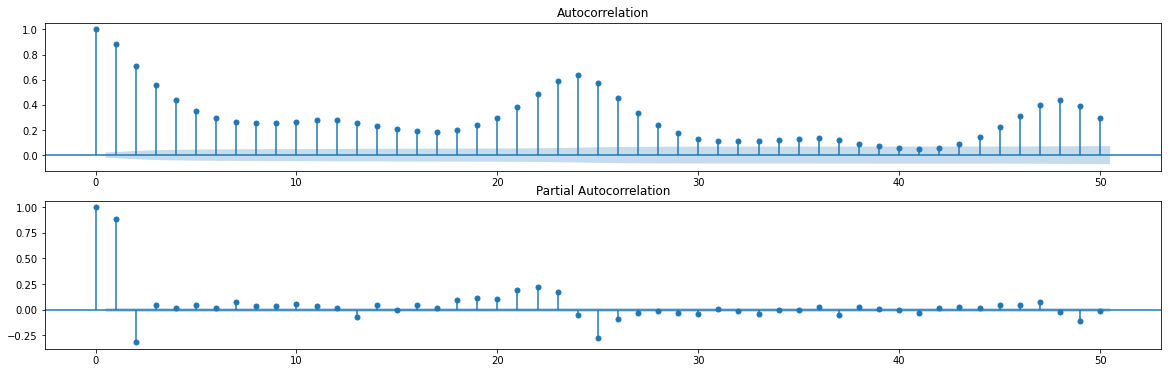

In [113]:
fig, ax = plt.subplots(2, figsize=(20,6))
ax[0] = plot_acf(dfn['PT08.S1(CO)'], ax=ax[0], lags=50)
ax[1] = plot_pacf(dfn['PT08.S1(CO)'], ax=ax[1], lags=50)
plt.show()

There are the strong correlation in 24 hour interval, and as we see before strong correlation in the previus value.

So we can to asset that there are seasonal autocorrelation.

# EXPERIMENT 1
## What is the best method to impute NA 

As I mentioned before there are groups of missing values. First of all I decided to start from the group with 366 na values. Na values are sattled in the same time period for all columns with group.

Becouse we don`t have enoght feutures to make regression I choose interpolatoin to solve this problem.

I have to choose which menthod of the interpolatoin is fits better.

The experiment:
    
    I will take the data frame which I made before where are no na values and generate series of na values. Then I count R squared scrore for all types of the interpolation, and choose the best fit menthod.
    

In [114]:
dfn.isna().sum()

PT08.S1(CO)              0
C6H6(GT)                 0
PT08.S2(NMHC)            0
PT08.S3(NOx)             0
PT08.S4(NO2)             0
PT08.S5(O3)              0
T                        0
RH                       0
AH                       0
PT08.S1(CO)_dif1         1
PT08.S1(CO)_dif1_lag1    2
dtype: int64

In [115]:
dfn = dfn.dropna(how='any')

In [116]:
#dfn.to_csv('data/interim/dfn_before_exp1.csv')

In [118]:
dfn_train = dfn.copy()

In [120]:
# add_na add to series groups of na values imitates missed values in origin dataset 
# TODO: index error and randonstate 
add_na(dfn['PT08.S1(CO)'], 50)

In [97]:
dfn.isna().sum()

PT08.S1(CO)              991
C6H6(GT)                   0
PT08.S2(NMHC)              0
PT08.S3(NOx)               0
PT08.S4(NO2)               0
PT08.S5(O3)                0
T                          0
RH                         0
AH                         0
PT08.S1(CO)_dif1           0
PT08.S1(CO)_dif1_lag1      0
dtype: int64

For each imputation method I assert new column

Imputing using interpolation with different methods

In [122]:
dfn = dfn.assign(InterpolateLinear = dfn['PT08.S1(CO)'].interpolate(method='linear'))
dfn = dfn.assign(InterpolateTime = dfn['PT08.S1(CO)'].interpolate(method='time'))
dfn = dfn.assign(InterpolateQuadratic = dfn['PT08.S1(CO)'].interpolate(method='quadratic'))
dfn = dfn.assign(InterpolateCubic = dfn['PT08.S1(CO)'].interpolate(method='cubic'))
dfn = dfn.assign(InterpolateSlinear = dfn['PT08.S1(CO)'].interpolate(method='slinear'))
dfn = dfn.assign(InterpolateAkima = dfn['PT08.S1(CO)'].interpolate(method='akima'))
dfn = dfn.assign(InterpolatePoly3 = dfn['PT08.S1(CO)'].interpolate(method='polynomial', order=3))
dfn = dfn.assign(InterpolatePoly5 = dfn['PT08.S1(CO)'].interpolate(method='polynomial', order=5))
dfn = dfn.assign(InterpolatePoly7 = dfn['PT08.S1(CO)'].interpolate(method='polynomial', order=7))

dfn = dfn.assign(InterpolateSpline3 = dfn['PT08.S1(CO)'].interpolate(method='spline', order=3))
dfn = dfn.assign(InterpolateSpline4 = dfn['PT08.S1(CO)'].interpolate(method='spline', order=4))
dfn = dfn.assign(InterpolateSpline5 = dfn['PT08.S1(CO)'].interpolate(method='spline', order=5))

Scoring the results and see which is better

In [132]:
results = [(method, r2_score(dfn_train['PT08.S1(CO)'][34:], dfn[method][34:])) for method in list(dfn)[13:]]
results_df = pd.DataFrame(np.array(results), columns=['Method', 'R_squared'])
results_df.sort_values(by='R_squared', ascending=False)

,Method,R_squared
0,InterpolateLinear,0.9288104872144433
1,InterpolateTime,0.9288104872144433
4,InterpolateSlinear,0.9288104872144433
5,InterpolateAkima,0.8900104892254077
2,InterpolateQuadratic,0.6523162807513391
9,InterpolateSpline3,0.6448488921087755
3,InterpolateCubic,0.6430003902255186
6,InterpolatePoly3,0.6430003902255186
7,InterpolatePoly5,-5.32990211138566
11,InterpolateSpline5,-5.2245394459042895


Conclusion.

I has concluded that the best way to resolve issue with na values in original data frame in group where are not enought information to make regression would be to use either Liner Interpolation or Time Interpolation.

In [133]:
#results_df.to_csv('data/final/results_exp1.csv')

In [134]:
df.to_csv('data/interim/df_after_exp1.csv')

In [135]:
df[c_366] = df[c_366].interpolate(method='linear')

In [138]:
df.isna().sum()

CO(GT)           1683
PT08.S1(CO)         0
NMHC(GT)         8443
C6H6(GT)            0
PT08.S2(NMHC)       0
NOx(GT)          1639
PT08.S3(NOx)        0
NO2(GT)          1642
PT08.S4(NO2)        0
PT08.S5(O3)         0
T                   0
RH                  0
AH                  0
dtype: int64

# Preliminary Outcome

The first issue have been solved with linear interpolation method. Next step is resolve issue with the second group of na consisting of three feature of group c_1700. I assume there is enought information to build linear regression model since it displayed satisfactory score. 

# Linear Regression to imputate na values

A major disadvantage in this method is that we reduce the inherent variability in the imputed variable. In other words, since we substitute the missing data with regression outputs, the predicted values lie along the regression hyperplane where the variable would have actually contained some noise/bias.



To add uncertainity back to the imputed variable values, we can add some normally distributed noise with a mean of zero and the variance equal to the standard error of regression estimates . This method is called as Random Imputation or Stochastic Regression Imputation


# Expirement 2

In this experiment I will count R squared score for Linear Regression with stochastic noise with cross validation.

I will do you same way as before
    
    1. I make a copy of dataframe
    2. Add some groups of missing values
    3. Use Linear Regression to fill this values
    4. Come to conclusion
    
In this experiment used the group of missing value c_1700 containing from 3 feature with 1700 missing values. For experiment purpose at the begining this feaure will be droped and another features without na values will be used.

In [153]:
df_exp2 = df.copy()

In [154]:
df_exp2 = df_exp2.drop(c_9000, axis=1)

In [155]:
df_exp2 = df_exp2.drop(c_1700, axis=1)

In [156]:
# df_exp2.to_csv('data/interim/df_before_exp2.csv')

In [157]:
df_exp2.isna().sum()

PT08.S1(CO)      0
C6H6(GT)         0
PT08.S2(NMHC)    0
PT08.S3(NOx)     0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64

In [158]:
df_exp2_res = df_exp2.copy()

In [162]:
add_na(df_exp2['PT08.S1(CO)'], 100)

In [178]:
df_exp2.isna().sum()

PT08.S1(CO)      2328
C6H6(GT)            0
PT08.S2(NMHC)       0
PT08.S3(NOx)        0
PT08.S4(NO2)        0
PT08.S5(O3)         0
T                   0
RH                  0
AH                  0
dtype: int64

In [164]:
missing_columns = ['PT08.S1(CO)']

In [165]:
parameters = list(set(df_exp2.columns) - set(missing_columns))

In [176]:
model = sm.OLS(df_exp2['PT08.S1(CO)'], df_exp2[parameters], missing='drop')
results = model.fit()

In [177]:
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:            PT08.S1(CO)   R-squared (uncentered):                   0.995
Model:                            OLS   Adj. R-squared (uncentered):              0.995
Method:                 Least Squares   F-statistic:                          1.775e+05
Date:                Fri, 18 Sep 2020   Prob (F-statistic):                        0.00
Time:                        12:05:42   Log-Likelihood:                         -40684.
No. Observations:                7029   AIC:                                  8.138e+04
Df Residuals:                    7021   BIC:                                  8.144e+04
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

Conclusion

R-squared (uncentred) and Adj. R-squared (uncentred) showed that model have described 99.5% of the variance in the taget feature.

The f-statistic and the relative p-value. The F value in regression is the result of a test where the null hypothesis is that all of the regression coefficients are equal to zero. In other words, the model has no predictive capability. Basically, the f-test compares your model with zero predictor variables (the intercept only model), and decides whether your added coefficients improved the model. If you get a significant result, then whatever coefficients you included in your model improved the model’s fit. 

Log-Likelihood score needed to make conclusions about different models. So not important here.

AIC and BIC its relatibly huge in this model, so I assume this model is really compicated, maybe becouse it`s time Series

P>|t| - is all low so its shows that all features in the model good fits.

Durbin-Watson - I dont know p-value for this test

the sample skewness and kurtosis are to the values 0 and 3

In [226]:
stats.shapiro(results.resid)

/home/egor/anaconda3/envs/py_3.8.5_j/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.994943380355835, pvalue=5.075707293567466e-15)

Shapiro test shows that OLS model residual with a huge confident are normaly distributed. 

# Experinet 3

Will the regulisation help to improve the model. R squared score will be counted for models with different kind of regulisation and GridSearchCV will be used to try different hyperporameters, best of them will be choose and showed it the table of R squared score for different types of model.

In [222]:
lasso_params = {'alpha':[0.02, 0.024, 0.025, 0.026, 0.03]}
ridge_params = {'alpha':[200, 230, 250,265, 270, 275, 290, 300, 500]}

In [223]:
models = {'OLS': linear_model.LinearRegression(),
           'Lasso': GridSearchCV(linear_model.Lasso(), 
                               param_grid=lasso_params).fit(df[parameters], df[missing_columns]).best_estimator_,
           'Ridge': GridSearchCV(linear_model.Ridge(), 
                               param_grid=ridge_params).fit(df[parameters], df[missing_columns]).best_estimator_,}


In [224]:
test(models, df_exp2_res, X = parameters, Y = missing_columns)

,OLS,Lasso,Ridge
0,0.879825,0.879808,0.877616
1,0.879883,0.879935,0.878558


**Conclusion**

We see that the simple linear regression shows not signifficantly different score as models with regularisation. So I will use the simple model for imputation.

# Imputation

In [231]:
# df.to_csv('data/interim/df_after_exp2.csv')

In [230]:
df_test = df.copy()

In [232]:
df_test.isna().sum()

CO(GT)           1683
PT08.S1(CO)         0
NMHC(GT)         8443
C6H6(GT)            0
PT08.S2(NMHC)       0
NOx(GT)          1639
PT08.S3(NOx)        0
NO2(GT)          1642
PT08.S4(NO2)        0
PT08.S5(O3)         0
T                   0
RH                  0
AH                  0
dtype: int64

In [242]:
df_test.drop('NMHC(GT)', axis=1, inplace=True)

In [301]:
df_test.drop('NOx(GT)', axis=1, inplace=True)
df_test.drop('NO2(GT)', axis=1, inplace=True)

In [302]:
df_na = df_test[df_test['CO(GT)'].isna().values]

In [303]:
model_na = linear_model.LinearRegression()

In [304]:
df_train = df_test.dropna(how='any', axis=0)

In [305]:
model_na.fit(df_train[list(set(df_train.columns) - set(['CO(GT)']))], df_train['CO(GT)'])

LinearRegression()

In [309]:
results_co = model_na.predict(df_na[list(set(df_na.columns) - set(['CO(GT)']))])

In [314]:
df['CO(GT)'][df['CO(GT)'].isna().values] = results_co

In [315]:
df.isna().sum()

CO(GT)              0
PT08.S1(CO)         0
NMHC(GT)         8443
C6H6(GT)            0
PT08.S2(NMHC)       0
NOx(GT)          1639
PT08.S3(NOx)        0
NO2(GT)          1642
PT08.S4(NO2)        0
PT08.S5(O3)         0
T                   0
RH                  0
AH                  0
dtype: int64

In [320]:
df_test = df.copy()
df_test.drop('NMHC(GT)', axis=1, inplace=True)
df_test.drop('CO(GT)', axis=1, inplace=True)
df_test.drop('NO2(GT)', axis=1, inplace=True)
df_na = df_test[df_test['NOx(GT)'].isna().values]
model_no = linear_model.LinearRegression()
df_train = df_test.dropna(how='any', axis=0)
model_no.fit(df_train[list(set(df_train.columns) - set(['NOx(GT)']))], df_train['NOx(GT)'])
results_co = model_na.predict(df_na[list(set(df_na.columns) - set(['NOx(GT)']))])
df['NOx(GT)'][df['NOx(GT)'].isna().values] = results_co

In [321]:
df_test = df.copy()
df_test.drop('NMHC(GT)', axis=1, inplace=True)
df_test.drop('CO(GT)', axis=1, inplace=True)
df_test.drop('NOx(GT)', axis=1, inplace=True)
df_na = df_test[df_test['NO2(GT)'].isna().values]

model_no = linear_model.LinearRegression()
df_train = df_test.dropna(how='any', axis=0)
model_no.fit(df_train[list(set(df_train.columns) - set(['NO2(GT)']))], df_train['NO2(GT)'])
results_co = model_na.predict(df_na[list(set(df_na.columns) - set(['NO2(GT)']))])
df['NO2(GT)'][df['NO2(GT)'].isna().values] = results_co

In [322]:
df.isna().sum()

CO(GT)              0
PT08.S1(CO)         0
NMHC(GT)         8443
C6H6(GT)            0
PT08.S2(NMHC)       0
NOx(GT)             0
PT08.S3(NOx)        0
NO2(GT)             0
PT08.S4(NO2)        0
PT08.S5(O3)         0
T                   0
RH                  0
AH                  0
dtype: int64

# Conclusion

I have tried different ways to solve imputation problem. Feature NMHC(GT) is not so relavant becouse it has a lot of na values. So I decide to delete it.

# Feature Enginiring

In [325]:
df[TARGET].describe()

count    9357.000000
mean       10.179155
std         7.503812
min         0.100000
25%         4.500000
50%         8.300000
75%        14.100000
max        63.700000
Name: C6H6(GT), dtype: float64

In [326]:
df['date'] = df.index
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['dayofmonth'] = df['date'].dt.day
df['quarter'] = df['date'].dt.quarter
df['dayofyear'] = df['date'].dt.dayofyear
df['weekofyear'] = df['date'].dt.isocalendar().week
df['dayofweek'] = df['date'].dt.dayofweek

In [331]:
df = df.assign(Diff1 = df[TARGET].diff())

In [332]:
df = df.assign(Diff2 = df['Diff1'].diff())

In [333]:
df = df.assign(Diff1_r = df['Diff1']/ df[TARGET])

In [334]:
df = df.assign(d_24 = df[TARGET].rolling(window=24).mean())

In [336]:
df = df.assign(exp_0_05 = exponential_smoothing(df[TARGET], 0.05))
df = df.assign(exp_0_03 = exponential_smoothing(df[TARGET], 0.03))
df = df.assign(exp_0_08 = exponential_smoothing(df[TARGET], 0.08))


In [337]:
df.to_csv('data/interim/df_feature.csv', index=True)

In [377]:
df = pd.read_csv('data/interim/df_feature.csv', index_col=[0], parse_dates=[0])

# Conclusion

I have made some non linear features ussing difference and exponential smoothing

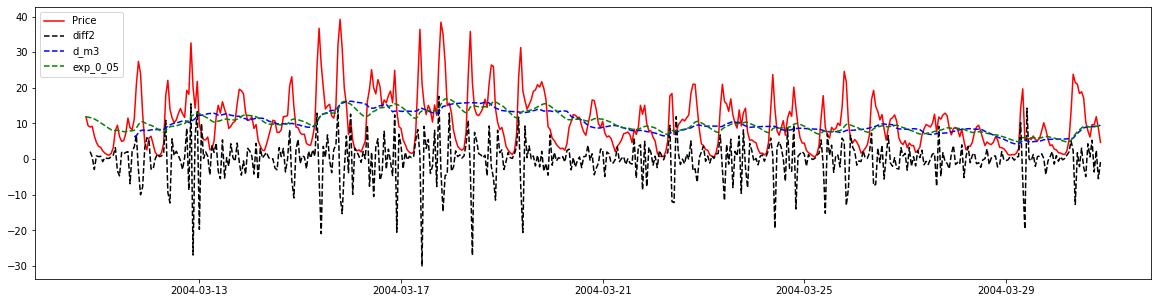

In [379]:
N100=484
plt.figure(figsize=(20,5))
plt.plot(df.index[:N100],df[TARGET][:N100],'r',label ='Price')
plt.plot(df.index[:N100],df['Diff2'][:N100],'--k',label ='diff2')
plt.plot(df.index[:N100],df['d_24'][:N100],'--b',label ='d_m3')
plt.plot(df.index[:N100],df['exp_0_05'][:N100],'--g',label ='exp_0_05')
plt.legend()
plt.show()

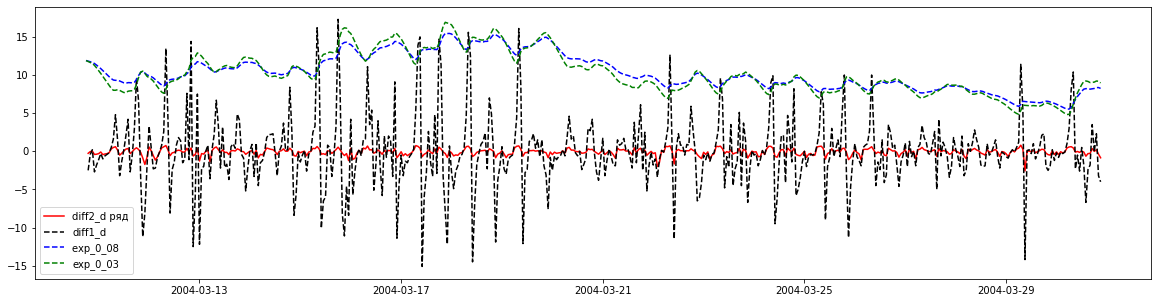

In [380]:
plt.figure(figsize=(20,5))
plt.plot(df.index[:N100],df['Diff1_r'][:N100],'r',label ='diff2_d ряд')
plt.plot(df.index[:N100],df['Diff1'][:N100],'--k',label ='diff1_d')
plt.plot(df.index[:N100],df['exp_0_03'][:N100],'--b',label ='exp_0_08 ')
plt.plot(df.index[:N100],df['exp_0_05'][:N100],'--g',label ='exp_0_03')
plt.legend()
plt.show()

# Feature Selecting



In [381]:
scl_target=StandardScaler() 

In [382]:
df.drop('d_24', axis=1, inplace=True)

In [383]:
df.drop('date', axis=1, inplace=True)

In [384]:
df.drop('NMHC(GT)', axis=1, inplace=True)

In [385]:
df.dropna(how='any', axis=0, inplace=True)

In [386]:
target_1  = df[TARGET].values.reshape(-1, 1)
y_1 = scl_target.fit_transform(target_1)
y_1.shape

(9355, 1)

In [394]:
TARGET

'C6H6(GT)'

In [395]:
scl_x=StandardScaler() 

X_1 = df.values
X_1 = scl_x.fit_transform(X_1.astype('float64'))
X_1.shape

(9355, 25)

In [396]:
f_test, _ = f_regression(X_1, y_1.ravel())
f_test /= np.nanmax(f_test)
for i in range(X_1.shape[1]):
    print("F-test={:.2f},  I={}".format(f_test[i],i))

F-test=0.21,  I=0
F-test=0.13,  I=1
F-test=-16395452568790.63,  I=2
F-test=1.00,  I=3
F-test=0.02,  I=4
F-test=0.04,  I=5
F-test=0.01,  I=6
F-test=0.05,  I=7
F-test=0.10,  I=8
F-test=0.00,  I=9
F-test=0.00,  I=10
F-test=0.00,  I=11
F-test=0.00,  I=12
F-test=0.00,  I=13
F-test=0.00,  I=14
F-test=0.00,  I=15
F-test=0.00,  I=16
F-test=0.00,  I=17
F-test=0.00,  I=18
F-test=0.00,  I=19
F-test=0.00,  I=20
F-test=0.00,  I=21
F-test=0.02,  I=22
F-test=0.01,  I=23
F-test=0.02,  I=24


In [397]:
sfk =SelectKBest(f_regression, k=6)
X_new1 =sfk.fit_transform(X_1, y_1.ravel())
X_new1.shape

(9355, 6)

In [398]:
column_names = df.columns[sfk.get_support()]
column_names

Index(['CO(GT)', 'PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)',
       'PT08.S4(NO2)', 'PT08.S5(O3)'],
      dtype='object')

In [399]:
sfp=SelectPercentile(f_regression, percentile=10)
X_new2 = sfp.fit_transform(X_1, y_1.ravel())
X_new2.shape

(9355, 3)

In [400]:
column_namesp = df.columns[sfp.get_support()]
column_namesp

Index(['CO(GT)', 'PT08.S1(CO)', 'PT08.S2(NMHC)'], dtype='object')

# Conclusion

So after F test and feature selection I have 6 most important features for the model. 'CO(GT)', 'PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)'

In [403]:
model = sm.OLS(df[TARGET], df[column_names])
results = model.fit()

# MODEL

In [417]:
train, test = split_data(df, '2005-03-25 05:00:00')

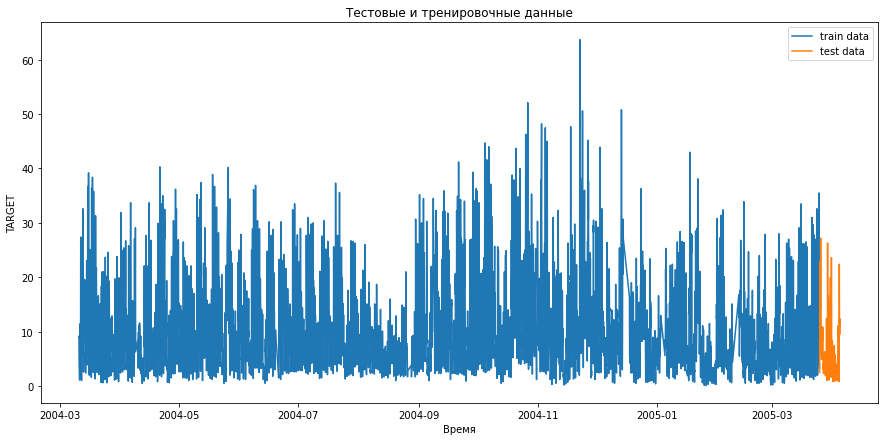

In [418]:
plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('TARGET')
plt.plot(train.index, train[TARGET], label='train data' )
plt.plot(test.index ,test[TARGET], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [437]:
x_train = train[list(set(column_names) - set(TARGET))]
y_train = train[TARGET]
x_test = test[list(set(column_names) - set(TARGET))]
y_test = test[TARGET]

In [438]:
model_g = GradientBoostingRegressor(max_depth=5, random_state=42, n_estimators=100)

In [445]:
model_g.fit(x_train, y_train)

GradientBoostingRegressor(max_depth=5, random_state=42)

In [446]:
y_test_pred_g = model_g.predict(x_test)

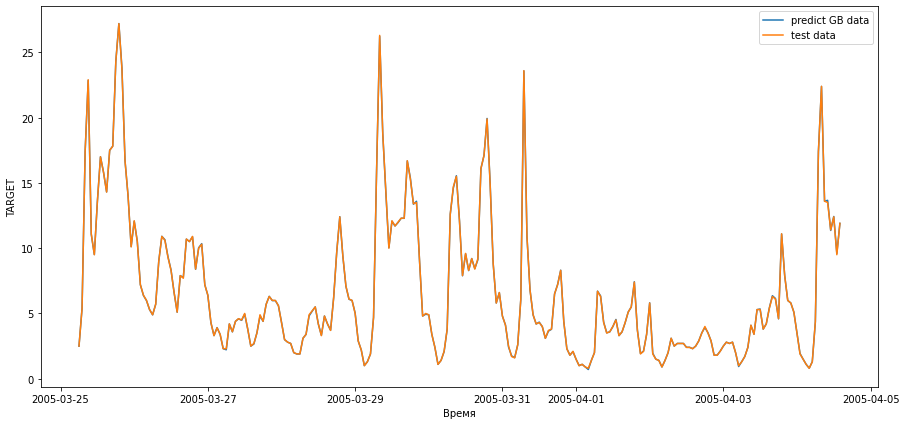

In [447]:
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('TARGET')
plt.plot(test.index, y_test_pred_g, label='predict GB data' )
plt.plot(test.index, y_test, label='test data')

plt.legend()
plt.show()

Я не знаю, что пошло не так, видимо, как я видел в результатах F теста есть единица, что очень странно. Думаю, отсюда ошибка 

# SECOND TRY 

In [453]:
m_1 = Model(df, h = 1, p = 14)

y shape after noramalize - (9340, 1)
X shape after normalize - (9340, 25)
Значения F-test
F-test=0.52,  I=0
F-test=0.54,  I=1
F-test=1.00,  I=2
F-test=0.99,  I=3
F-test=0.15,  I=4
F-test=0.27,  I=5
F-test=0.06,  I=6
F-test=0.28,  I=7
F-test=0.44,  I=8
F-test=0.01,  I=9
F-test=0.00,  I=10
F-test=0.01,  I=11
F-test=0.01,  I=12
F-test=0.01,  I=13
F-test=0.00,  I=14
F-test=0.01,  I=15
F-test=0.01,  I=16
F-test=0.01,  I=17
F-test=0.01,  I=18
F-test=0.07,  I=19
F-test=0.00,  I=20
F-test=0.06,  I=21
F-test=0.11,  I=22
F-test=0.09,  I=23
F-test=0.14,  I=24
SelectKBest  shape - (9340, 6)
SelectKBest  shape - (9340, 3)
GradientBoostingRegressor - (9340, 3)
Номера признаков k лучших признаков :  [0 1 2 3 7 8]
Номера признаков лучших признаков по процентной форме:  [1 2 3]
Номера признаков для выбора по модели :  [ 2  3 19]
Самые важные фичи - [ 1  2  3 19]


In [455]:
r_1 = Split_data(df, m_1.X_n, m_1.y, split_date = '2005-03-25 05:00:00')

In [459]:
model_g_1 = GradientBoostingRegressor(max_depth=5, random_state=42, n_estimators=100)

In [460]:
model_g_1.fit( r_1.X_train, r_1.y_train )

GradientBoostingRegressor(max_depth=5, random_state=42)

In [461]:
y_test_pred_g_1 = model_g_1.predict(r_1.X_test)

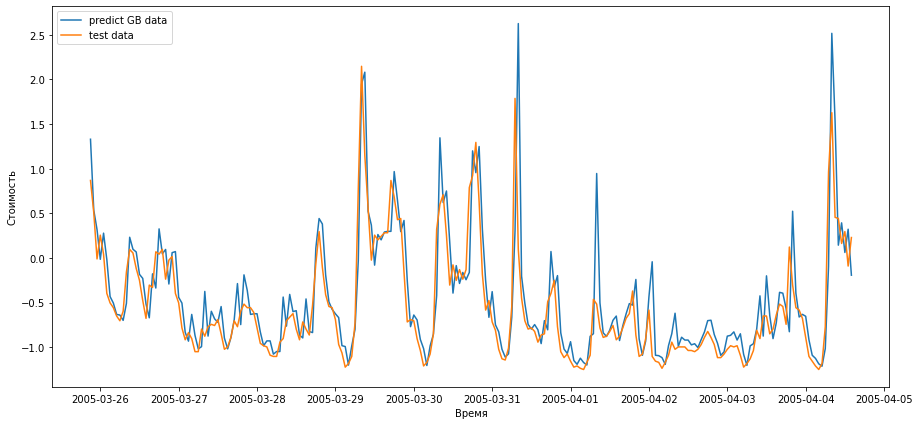

In [462]:
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Стоимость')
plt.plot(r_1.test_index.index[m_1.h+m_1.p:],y_test_pred_g_1, label='predict GB data' )
plt.plot(r_1.test_index.index[m_1.h+m_1.p:],r_1.y_test, label='test data')

plt.legend()
plt.show()

Эта модель тоже не хороша для использования, так как показывает очевидный лаг. Но она уже намного лучше предыдущей

In [465]:
e_1 = Error_count(r_1.y_test, y_test_pred_g_1, m_1.scl_target)

ошибка mse :   0.13206021039247282 
ошибка mae  :   0.22506933858205805 
оценка R2 :   0.6493440854724173
#TODO тут явно ошибка вычисления
ошибка градиентного бустинга MAPE : 122.42846596001664 %


In [469]:
model = sm.OLS(df[TARGET], df[column_names], missing='drop')
results = model.fit()

In [470]:
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:               C6H6(GT)   R-squared (uncentered):                   0.981
Model:                            OLS   Adj. R-squared (uncentered):              0.981
Method:                 Least Squares   F-statistic:                          8.156e+04
Date:                Mon, 21 Sep 2020   Prob (F-statistic):                        0.00
Time:                        14:31:47   Log-Likelihood:                         -18410.
No. Observations:                9355   AIC:                                  3.683e+04
Df Residuals:                    9349   BIC:                                  3.688e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------